# CSE 519 HW3
## Tyler Estro (), Noushin Salek Faramarzi (), Tim Zhang (110746199)

# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import zscore

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,20)

In [2]:
# Load dataset as data matrix X
X = pd.read_csv(open("properties_2017.csv", "rb"))

/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Scoring Function

## Feature Selection and Imputation

One of the most important features of a house is size.  For this reason, we have selected a curated feature set involving mainly this attribute.  While size is an important attribute, the layout of a house is also very important.  Thus we also included properties of layout, such as the counts of bedrooms, bathrooms, and the size of garages.  Additionally, age seems to be an important aspect of a home so we include this feature as well.

We will consider the following features for our scoring function:
* 'bathroomcnt' 
* 'bedroomcnt'
* 'calculatedfinishedsquarefeet'
* 'taxamount'
* 'yearbuilt'
* 'basementsqft'
* 'garagetotalsqft' 
* 'buildingqualitytypeid'

In [3]:
scoring_features = X[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount']]

We employ a custom imputation scheme.

* For each of the features in scoring_features we will use median imputation, since for of these domains the median seems to be a reasonable and robust method.

* For both basementsqft and garagetotalsqft, it seems a more reasonable assumption that if there is no record of these fields the property may simply not have a basement or a garage.  Thus we impute with a value of 0.

* Finally, ID based features should be imputed using the mode of the sample.  It seems reasonable that the most frequent ID in the dataset would continue to be most frequent.

In [4]:
imputed_scoring_features = scoring_features.fillna(scoring_features.median())
imputed_yearbuilt = X['yearbuilt'].fillna(X['yearbuilt'].median())
imputed_scoring_features['basementsqft'] = X['basementsqft'].fillna(0)
imputed_scoring_features['garagetotalsqft'] = X['garagetotalsqft'].fillna(0)
imputed_scoring_features['buildingqualitytypeid'] = X['buildingqualitytypeid'].fillna(X['buildingqualitytypeid'].mode()[0])

We create a custom 'age' feature by subtracting the current year by yearbuilt.

In [5]:
imputed_scoring_features['age'] = 2017 - imputed_yearbuilt

## Exploratory Analysis and Cleaning

Next it seems prudent to plot the distributions of our features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12901d290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118e448d0>]], dtype=object)

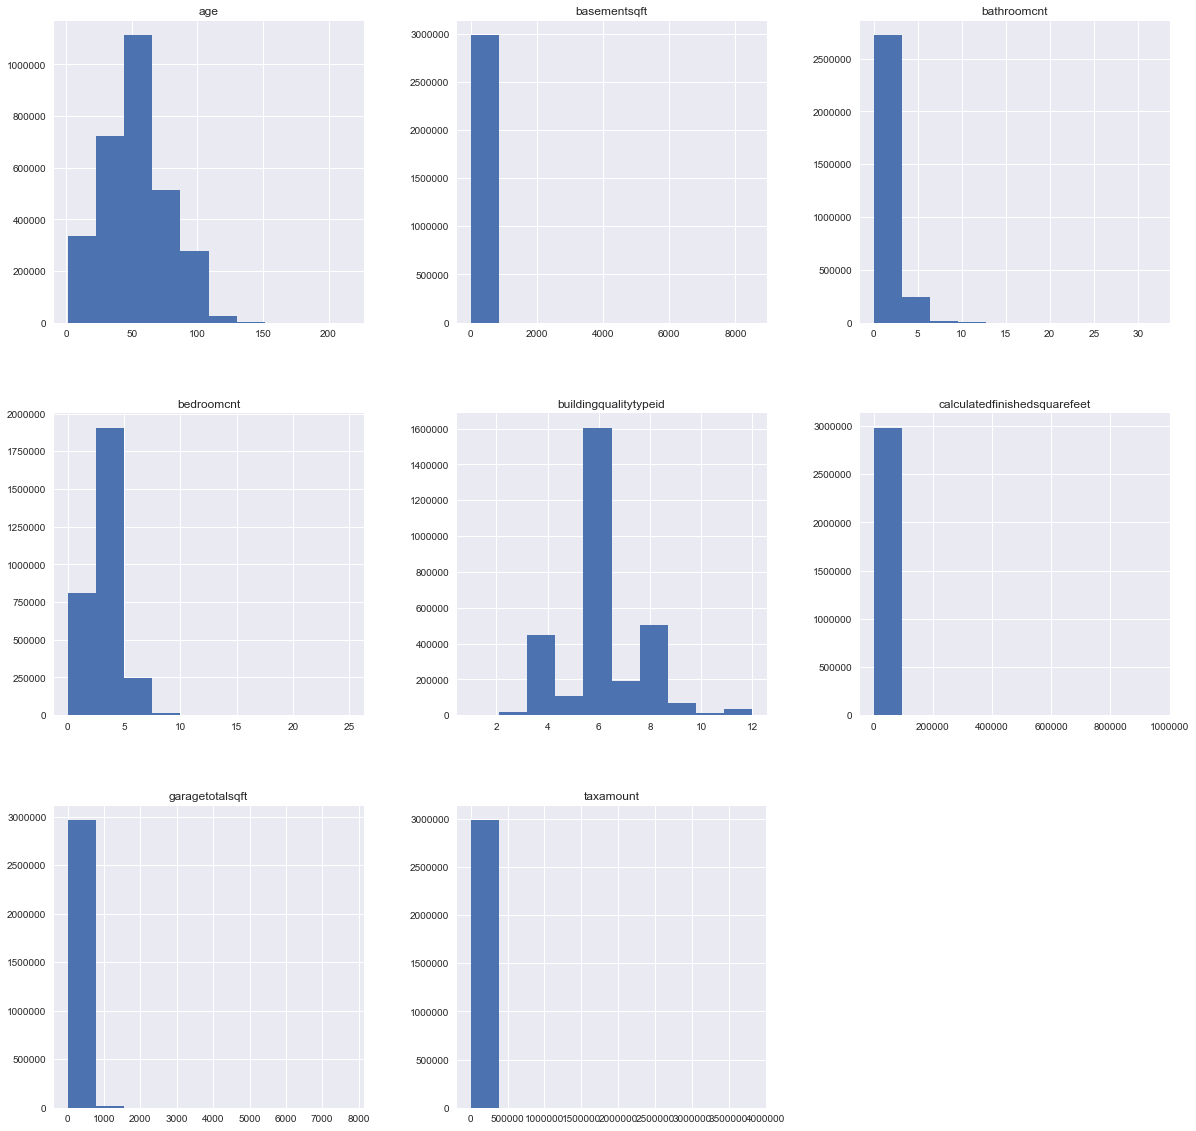

In [6]:
imputed_scoring_features.hist()

Many of our plots seem uninfomative.  Let us try using a log-y plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a44b910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118bb3190>]], dtype=object)

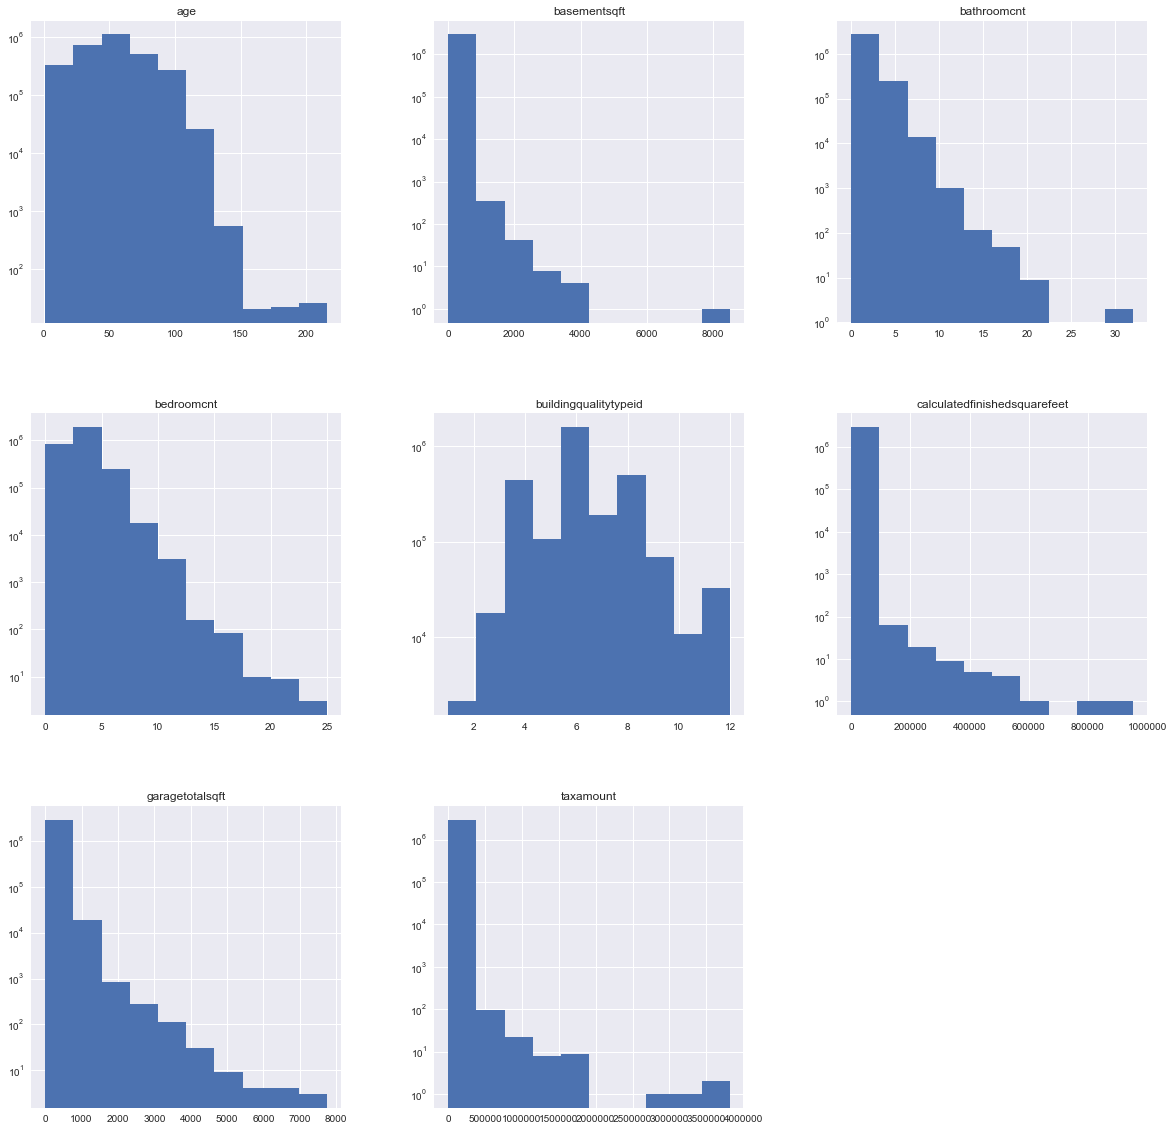

In [7]:
imputed_scoring_features.hist(log=True)

Observing the plots above leads to an observation that some of the features seem to have heavy outliers.  In particular let us apply the log to 'basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', and 'taxamount'.

In [8]:
imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']] = imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']].apply(np.log).replace([np.inf, -np.inf], 0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118feefd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bc2fa10>]], dtype=object)

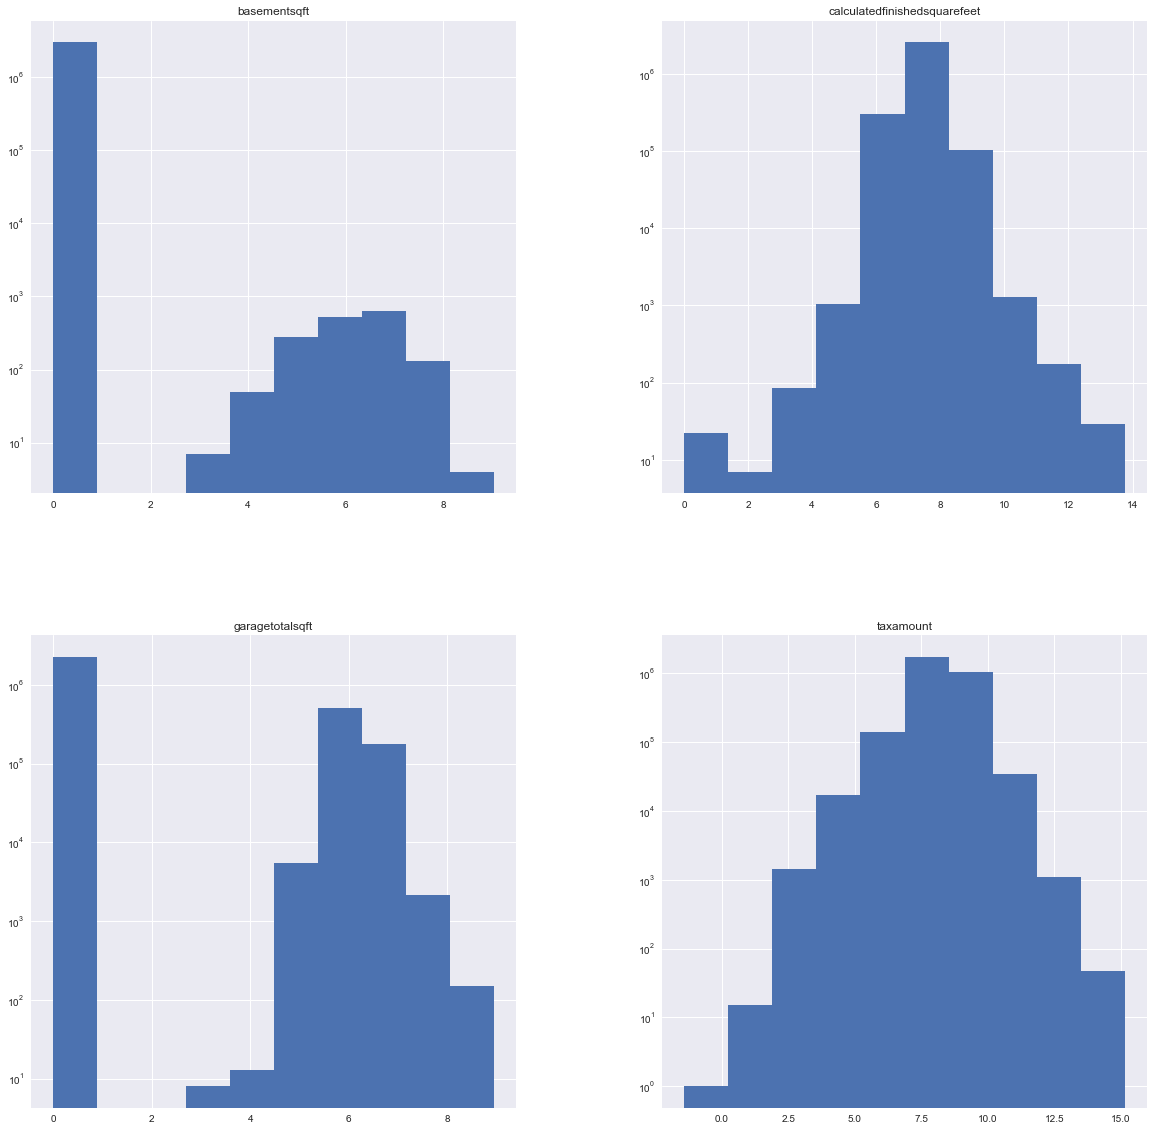

In [9]:
imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']].hist(log=True)

Plotting the above log-features shows roughly normally distributed values.  'basementsqft' and 'garagetotalsqft' both exhibit bimodal behavior due to the imputation strategy of 0-replacement.

Finally, let us apply z-score normalization to our entire feature matrix.

In [10]:
cleaned_scoring_features = imputed_scoring_features.apply(zscore)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bd42750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119449a10>]], dtype=object)

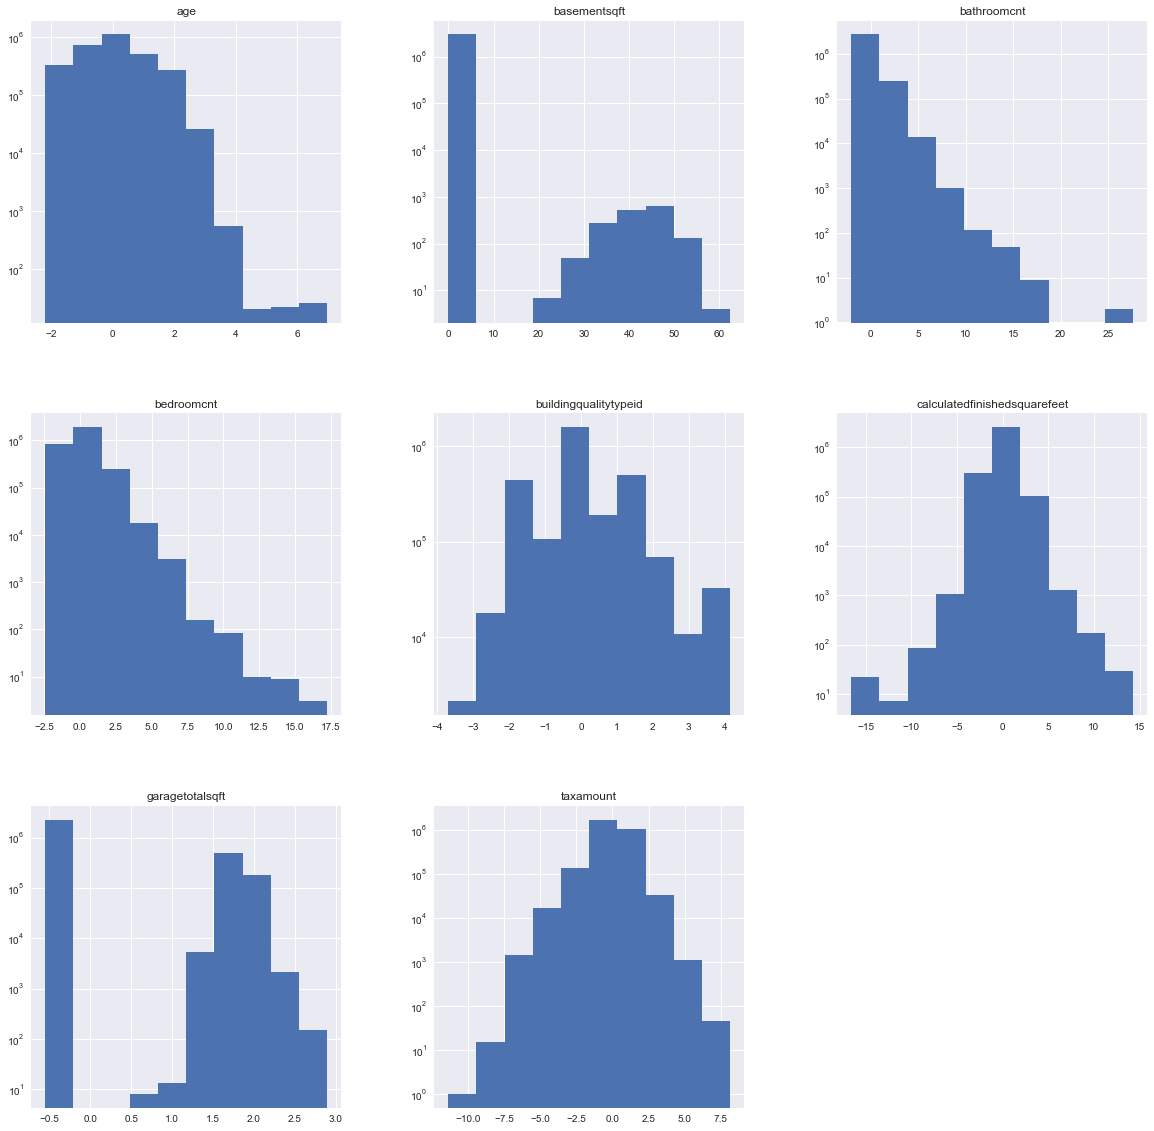

In [11]:
cleaned_scoring_features.hist(log=True)

In [12]:
print cleaned_scoring_features['basementsqft'].mean()

7.76368570049e-15


It seems that most of our features exhibit roughly symmetric normal empirical distributions.  We are now in a position to create a scoring function and rank our dataset.

## Scoring and Ranking

After z-score nomalization some of our data is still not conforming to a standard range.  To alleviate this we will apply the following weighted formulation as our scoring function: 

$- \text{age} + 0.1 \times \text{basementsqft} + 0.2 \times \text{bathroomcnt} + 0.5 \times \text{bedroomcnt} - \text{buildingqualitytypeid} + \text{calculatedfinishedsquarefeet} + 2 \times \text{garagetotalsqft} - \text{taxamount}$

Where we try to constrain the ranges within -10 and 10 and apply positive or negative weightings based on the features contribution to the score.  So for example, taxamount has a negative weighting since higher taxes are unfavorable given other similar features such as the size of the residence.

In [13]:
scores = (-1 * cleaned_scoring_features['age']) + (.1 * cleaned_scoring_features['basementsqft']) + (.2 * cleaned_scoring_features['bathroomcnt']) - cleaned_scoring_features['buildingqualitytypeid'] + cleaned_scoring_features['calculatedfinishedsquarefeet'] + (2 * cleaned_scoring_features['garagetotalsqft']) - cleaned_scoring_features['taxamount'] 

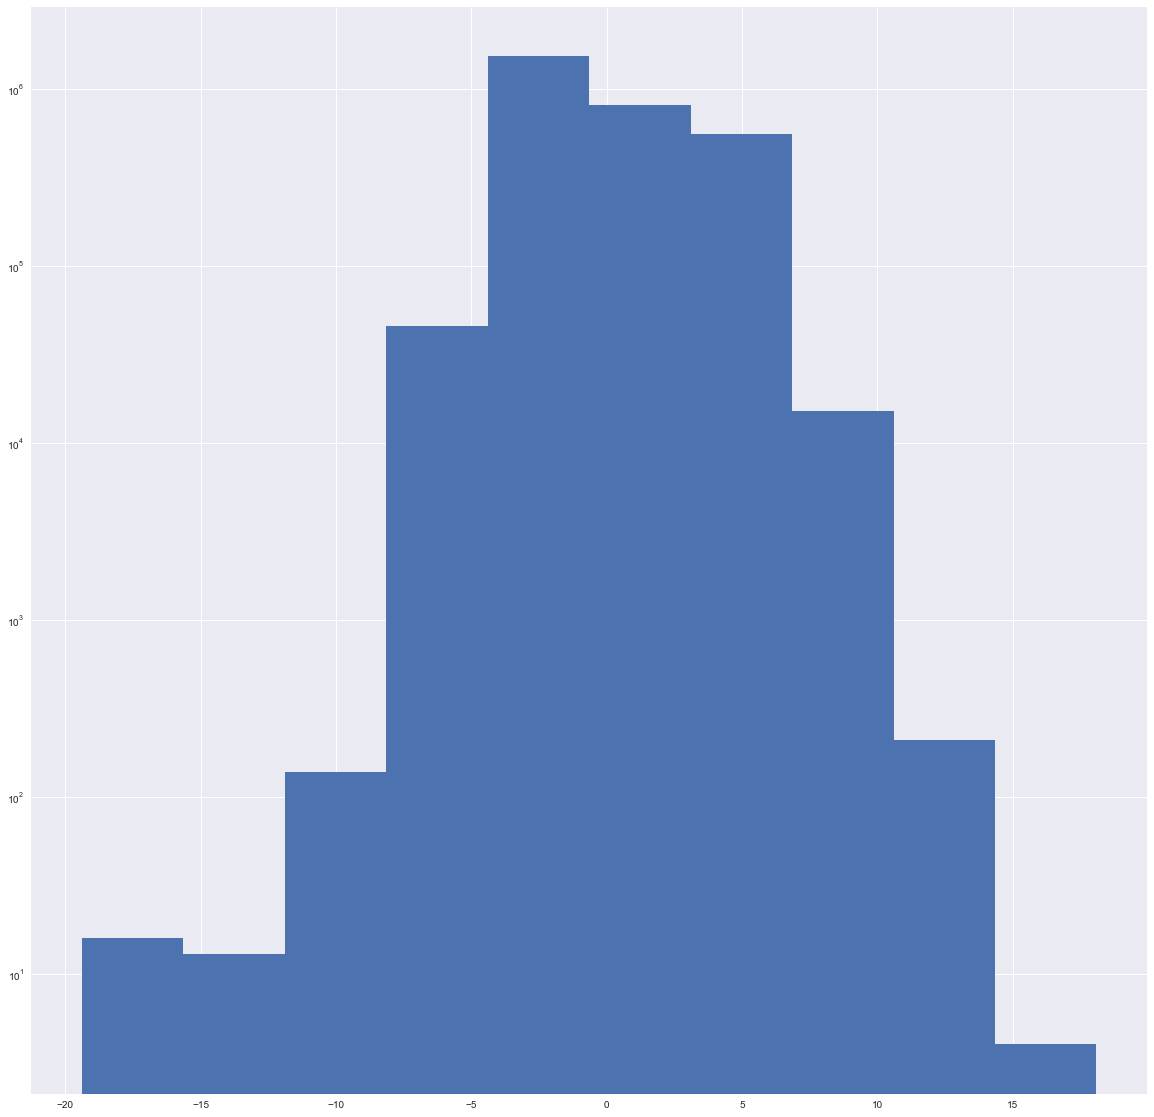

In [14]:
scores.hist(log=True)

We find the ten most desirable houses to have the following scores:

In [15]:
print scores.nlargest(10)
high_keys = scores.nlargest(10).index.values

44260      18.089934
254641     15.391203
2580864    14.962506
1520509    14.490833
686667     13.991205
717115     13.948202
1119623    13.895747
224142     13.750932
1358276    13.426263
2819482    13.391344
dtype: float64


We find the ten least desirable houses to have the following scores:

In [16]:
print scores.nsmallest(10)
low_keys = scores.nsmallest(10).index.values

814108    -19.384326
1003848   -18.812566
1137975   -18.560778
945956    -18.214160
1998676   -17.807948
1972644   -17.802562
170311    -17.661849
80982     -17.345340
2626112   -17.063251
481596    -16.979142
dtype: float64


Using the fact that the indices were never permuted in our subsampling and cleaning, we can match row IDs to find the parcelid of the best residences.

In [17]:
print X['parcelid'][high_keys]

44260      14337760
254641     17284931
2580864    17284985
1520509    17291058
686667     17124760
717115     17284849
1119623    17285067
224142     17124713
1358276    17284878
2819482    17300810
Name: parcelid, dtype: int64


The least desirable houses are as follows:

In [18]:
print X['parcelid'][low_keys]

814108     12703541
1003848    11645321
1137975    11651552
945956     12152324
1998676    12546681
1972644    11490532
170311     12147406
80982      12186499
2626112    10856270
481596     11590140
Name: parcelid, dtype: int64


As a sanity check, let's print the imputed feature values for the best and worst houses.

Most desirable houses:

In [19]:
print imputed_scoring_features.iloc[high_keys]

         bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  taxamount  \
44260           19.5        10.0                     10.179034   5.911013   
254641           8.5         4.0                      9.429556  10.949114   
2580864          9.5         6.0                      9.177611  10.438781   
1520509          9.5         6.0                      9.804606  12.553423   
686667           6.0         4.0                      9.077266   9.983234   
717115           9.0         6.0                      9.261984  10.977144   
1119623          9.5         6.0                      9.089753  10.212595   
224142           7.5         5.0                      9.268987   9.931579   
1358276          8.0         7.0                      9.634235  10.605467   
2819482          8.0         5.0                      8.532279   9.569794   

         basementsqft  garagetotalsqft  buildingqualitytypeid   age  
44260        0.000000         8.029107                    6.0  36.0  
254641      

Here we see that the most desirable houses indeed seem pretty desirable having large finished area, spacious basements and garages, and many bedrooms.

Least desirable houses:

In [20]:
print imputed_scoring_features.iloc[low_keys]

         bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  taxamount  \
814108           3.0         4.0                      0.693147   9.567997   
1003848          7.0         5.0                      1.945910   9.910473   
1137975          4.0         1.0                      1.098612   9.999326   
945956           3.0         2.0                      1.098612   9.274048   
1998676          0.0         1.0                      0.000000   6.558538   
1972644          2.0         3.0                      0.000000   8.328804   
170311           2.0         2.0                      1.098612   8.827997   
80982            1.0         2.0                      0.000000   7.599076   
2626112          5.0         5.0                      0.000000   8.825977   
481596          15.0         2.0                      0.693147  10.078398   

         basementsqft  garagetotalsqft  buildingqualitytypeid    age  
814108            0.0              0.0                    8.0   65.0  
1003848   

The very worst houses seem terrible with high taxes and almost not finished square feetage.  Additionally, these houses are old, and in a generally poor state of disrepair.  However, it is quite possible that the 'calculatedfinishedsquarefeet' for these houses are input errors or due to some technicality.  It is also possible that these are historical properties given their age.

## Report

Although there is certainly room for improvement, our simple scoring function has withstood the sniff test.  It seems to really find some difference in the desirability of the properties that translates into a real world interpretation.  The best houses are spacious, with many bedrooms and other such luxeries.  The worst houses (according to the data) have terrible proportions of finished square feetage to taxation, along with general disrepair.

# Distance Function

# Clustering

# External Dataset Integration

# Improved Model

# Permutation Test